# Binning Studies

## Table of Contents
- [DNN output](#DNNoutput)<a href='#DNNoutput'></a> <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
import os

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "em_loose",
    "model_version":   "v3"
}

In [3]:
config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [4]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [5]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

#X[~np.isfinite(X)] = 9999

In [6]:
scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
X_scaled = scaler.fit_transform(X)

In [7]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()

W0505 16:14:31.699261 140118091585344 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0505 16:14:32.481981 140118091585344 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                420       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

In [8]:
bkg_linf = bkg[config["cols"]].values
#bkg_linf[~np.isfinite(bkg_linf)] = 9999

<a id = 'DNNoutput' ></a>
## DNN output

In [9]:
bkg["y"] = model.predict(scaler.transform(bkg_linf), batch_size=2048)
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)

In [10]:
top = bkg[bkg["sample_name"] == "top"]

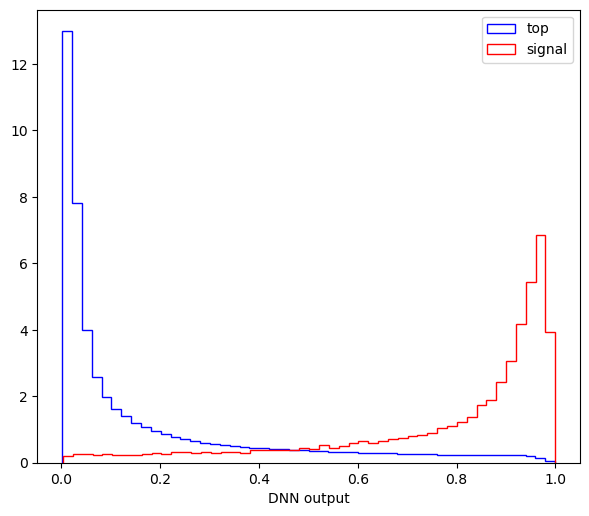

In [11]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(top["y"],   bins=50, density=True, label="top",    histtype="step", color="blue")
plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step", color="red")
plt.xlabel("DNN output")
plt.legend()
plt.show()

 Initial number of background events = 299226.73
 Initial number of signal events = 518.35

 signal efficiency = 0.7832
 background efficiency = 0.1013

 significance (before) = 0.95 
 significance (after) = 2.33


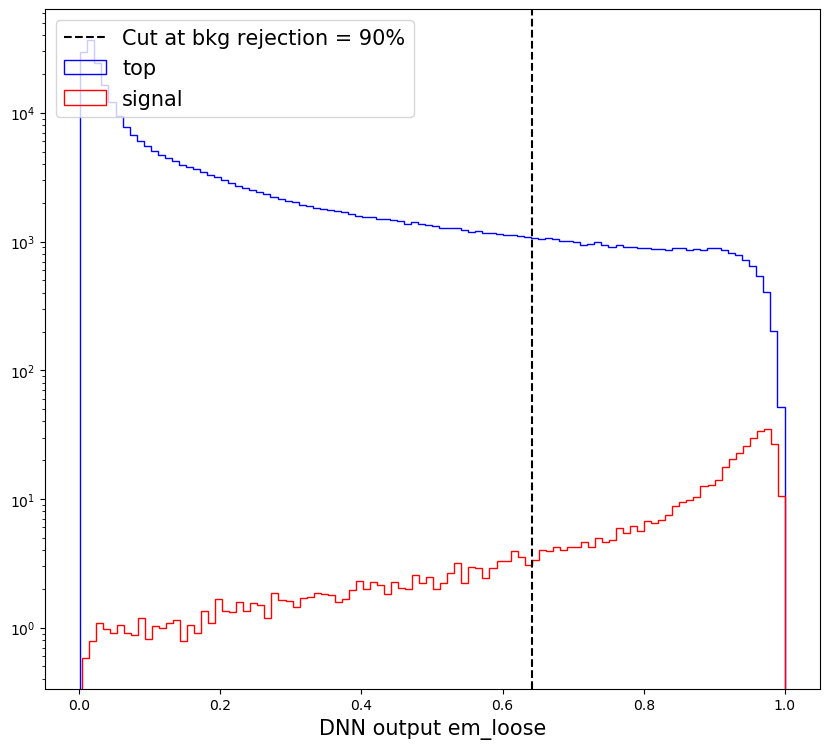

In [13]:
from math import sqrt
import matplotlib.patches as mpatches

lumi = 59.74

fig, ax1 = plt.subplots(figsize=(10,9), dpi=100)

B, B_bins, _ = plt.hist(top["y"],   weights=top.weight_*lumi, bins=100, label="top",  color="blue", histtype="step")
S, S_bins, _ = plt.hist(signal["y"], weights=signal.weight_*lumi, bins=100, label="signal", color="red", histtype="step")

Ni_B = sum(B)
Ni_S = sum(S)

print(" Initial number of background events = {:.2f}\n Initial number of signal events = {:.2f}\n".format(Ni_B, Ni_S))

bd = 1
int_B = 0

while (int_B < (0.1*Ni_B)):
    int_B = sum(B[-bd:])
    bd += 1

int_S = sum(S[-bd:])

plt.axvline(S_bins[-bd], 0, max(B), label='Cut at bkg rejection = 90%', color = "black", linestyle = "dashed")

print(" signal efficiency = {:.4f}\n background efficiency = {:.4f}\n".format(int_S/Ni_S, int_B/Ni_B))

print(" significance (before) = {:.2f} \n significance (after) = {:.2f}".format(Ni_S/sqrt(Ni_B), int_S/sqrt(int_B)))

plt.yscale("log")
plt.xlabel("DNN output "+config["cut"], fontsize=15)
plt.legend(loc="upper left", fontsize=15)
plt.show()

In [118]:
(signal.weight_).sum()*lumi

518.3514114152525

In [119]:
(bkg.weight_).sum()*lumi

299226.7260042991

In [138]:
sig = signal.loc[(signal['y']> 0.65)]
back = bkg.loc[(bkg['y']> 0.65)]

In [139]:
(sig.weight_).sum()*lumi

378.3558059490487

In [140]:
(back.weight_).sum()*lumi

30648.432910998057

In [141]:
(sig.weight_).sum()*lumi / sqrt((back.weight_).sum()*lumi)

2.1612065045928683